# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only
Agent can only bet a fixed amount quantity

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DQN

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_Restrict_TradeEnv

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'])

In [3]:
best_params

{'OPEN_THRE': 1.3,
 'CLOS_THRE': 0.05,
 'period': 700,
 'verbose': 0,
 'prefix': 'Gridsearch',
 'kellycriterion': False,
 'fixed_amount': 0.1}

In [4]:
df.tail(10)

,time,close0,itvl,datetime,close1,spread,zscore
521369,1703818259999,0.000026,1m,2023-12-29 02:50:59.999,0.000028,-0.000002,-0.396319
521370,1703818319999,0.000026,1m,2023-12-29 02:51:59.999,0.000028,-0.000002,-0.396239
521371,1703818379999,0.000026,1m,2023-12-29 02:52:59.999,0.000028,-0.000002,-0.420932
521372,1703818439999,0.000026,1m,2023-12-29 02:53:59.999,0.000028,-0.000002,-0.386968
521373,1703818499999,0.000026,1m,2023-12-29 02:54:59.999,0.000028,-0.000002,-0.389093
521374,1703818559999,0.000026,1m,2023-12-29 02:55:59.999,0.000028,-0.000002,-0.207767
521375,1703818619999,0.000026,1m,2023-12-29 02:56:59.999,0.000028,-0.000002,-0.164779
521376,1703818679999,0.000026,1m,2023-12-29 02:57:59.999,0.000028,-0.000002,-0.119399
521377,1703818739999,0.000026,1m,2023-12-29 02:58:59.999,0.000028,-0.000002,0.200959
521378,1703818799999,0.000026,1m,2023-12-29 02:59:59.999,0.000028,-0.000002,0.873463


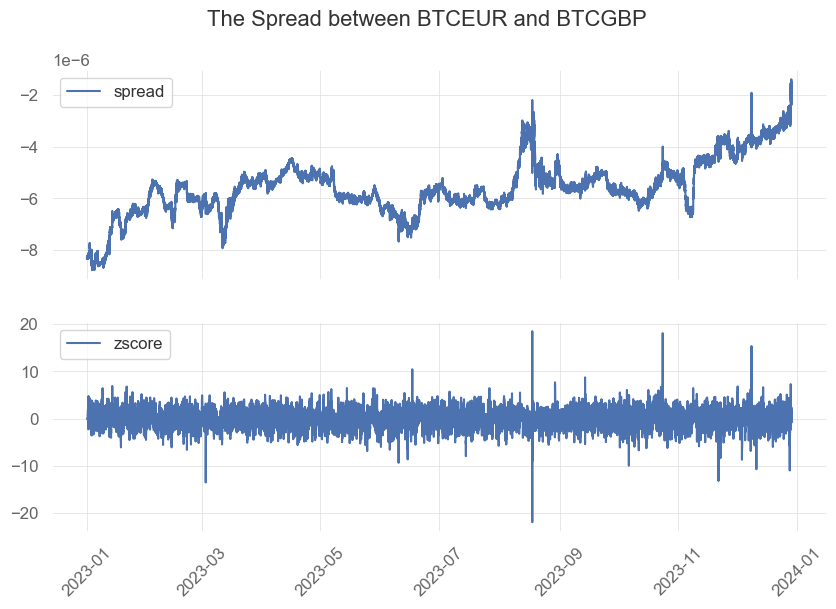

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [6]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period']) * 0.95)
print(f"The length of our training data: {len(train)}")

The length of our training data: 87840


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [7]:
from stable_baselines3.common.env_checker import check_env

env = RL_Restrict_TradeEnv(train)
obs, _ = env.reset()
check_env(env)

Tensorboard

## Train the Model with Trading Env

In [8]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/A2C_1
Deleted: logs/restrict_thres/DQN_1
Deleted: logs/restrict_thres/PPO_1


In [9]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=True)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

Output()

In [10]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

Output()

In [11]:
'''DQN'''

model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_dqn.learn(total_timesteps=max_train_len, progress_bar=True)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

Output()

## Create the Custom Test Env

In [12]:
test_env_ppo = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_dqn = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_dqn.csv", verbose=1)
test_env_expt = RL_Restrict_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [13]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

The length of our test data: 38475


## Test Env with Trained Model

In [14]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

  0%|          | 13/38475 [00:00<05:04, 126.35it/s]

signal: {'position': 1, 'zone': 0, 'zscore': array([3.697308])}, action: 0, reward:1.0, networth: 1.0


 10%|█         | 3867/38475 [00:40<05:48, 99.36it/s] 

signal: {'position': array(1, dtype=int64), 'zone': 3, 'zscore': array([-0.10806032])}, action: 1, reward:1.0, networth: 1.0076


 20%|██        | 7715/38475 [01:14<04:02, 126.65it/s]

signal: {'position': array(0, dtype=int64), 'zone': 1, 'zscore': array([1.19648429])}, action: 0, reward:1.0, networth: 1.0108


 30%|███       | 11563/38475 [01:47<03:53, 115.02it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.78748593])}, action: 1, reward:1.0, networth: 1.0252


 40%|████      | 15410/38475 [02:20<03:16, 117.61it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.53174725])}, action: 1, reward:1.0, networth: 1.036


 50%|█████     | 19254/38475 [02:55<02:41, 118.96it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.78440887])}, action: 0, reward:1.0, networth: 1.0492


 60%|██████    | 23104/38475 [03:28<02:08, 119.82it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.19242718])}, action: 1, reward:1.0, networth: 1.0629


 70%|███████   | 26950/38475 [04:02<01:38, 116.59it/s]

signal: {'position': array(2, dtype=int64), 'zone': 3, 'zscore': array([-0.76275417])}, action: 2, reward:1.0, networth: 1.0838


 80%|████████  | 30793/38475 [04:36<01:06, 115.36it/s]

signal: {'position': array(0, dtype=int64), 'zone': 0, 'zscore': array([1.33974132])}, action: 0, reward:1.0, networth: 1.1056


 90%|█████████ | 34635/38475 [05:12<00:34, 111.28it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.49405665])}, action: 1, reward:1.0, networth: 1.1319


100%|██████████| 38475/38475 [05:46<00:00, 111.06it/s]

signal: {'position': array(1, dtype=int64), 'zone': 1, 'zscore': array([0.29127686])}, action: 1, reward:1.0, networth: 1.1618
Finished
networth: 1.161758678546551


In [ ]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

In [ ]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
except OSError:
    pass

obs, _ = test_env_dqn.reset()

for i in trange(max_test_len):
    action, _states = model_dqn.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_dqn.step(action)
    if i%int(max_test_len/10)==0:
        test_env_dqn.render()

test_env_dqn.close()

## Also run randomly generated actions

In [ ]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

### Analyze with Quanstats

In [ ]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

In [ ]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

In [ ]:
best_return

In [ ]:
best_return[best_return['pnl']!=0]

In [ ]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

In [ ]:
qs.reports.basic(best_return['returns'])